# **Predicting average house prices in the 33 London boroughs**

Extract dataset from Kaggle API

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload  Kaggle API key (kaggle.json file) from Kaggle account (Please click on choose files Button and select API file)
uploaded = files.upload()

# Move the uploaded file to the correct directory
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# https://www.kaggle.com/datasets/justinas/housing-in-london/data

!kaggle datasets download -d justinas/housing-in-london

  0% 0.00/169k [00:00<?, ?B/s]
100% 169k/169k [00:00<00:00, 87.6MB/s]


In [ ]:
#Unziping Housing-in-london folder, folder has 2 files,we will be using housing_in_london_monthly_variables.csv
!unzip housing-in-london.zip

Archive:  housing-in-london.zip
  inflating: housing_in_london_monthly_variables.csv  
  inflating: housing_in_london_yearly_variables.csv  


In the Google Colab notebook, the Kaggle package is installed, and the Kaggle API key is uploaded to facilitate dataset access. (Create Kaggle account and Kaggle API can be downloaded from Account tab of user profile). The key is securely moved and permissions are set. Subsequently, the "housing-in-london" dataset is downloaded from Kaggle, and its contents are extracted using the unzip command & load dataset.

# **Importing Libraries**

In [ ]:
#Importing relevant libraries to predict House prices project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import plotly.graph_objects as go
import re
import plotly.express as px
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
#Import dataset in CSV form downloaded from Kaggle website (If kaggle api is used,file will be there in interface directory)
df = pd.read_csv("housing_in_london_monthly_variables.csv")

The dataset, obtained in CSV format from the Kaggle website, is named "housing_in_london_monthly_variables.csv."

In [ ]:
df.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


In [ ]:
#Understanding the Houseing Dataset: Number of Rows and Columns
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 13549, Columns: 7


Information about a DataFrame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB


- no_of_crimes have only 7439 non-null values, meaning that 6110 dates are
missing crime features.
- houses_sold has 94 NAN values, meaning no houses were sold during these months.
- average_price, houses_sold,and no_of_crimes are numerical/float values
- area and borough_flag are categorical values even though borough_flag is currently a integer data type

## **Merge Dataframe** : Merging Monthly and Yearly dataset (Project analysis is performed on monthly dataset(df), for demonstration purpose i am merging monthly and yearly dataset)





In [ ]:
#Importing 2 dataset
data_monthly = pd.read_csv('housing_in_london_monthly_variables.csv')
data_yearly = pd.read_csv('housing_in_london_yearly_variables.csv')

#Converting date column into datetime object and extracting year column
data_monthly["date"] = pd.to_datetime(data_monthly["date"])
data_monthly["year"] = pd.DatetimeIndex(data_monthly["date"]).year
data_yearly["date"] = pd.to_datetime(data_yearly["date"])
data_yearly["year"] = pd.DatetimeIndex(data_yearly["date"]).year

#Merging dataframe using year and code column
Merged_df = pd.merge(data_yearly,data_monthly,on=["year","code"])
print(Merged_df.head())

        code          area_x     date_x  median_salary  life_satisfaction  \
0  E09000001  city of london 1999-12-01        33020.0                NaN   
1  E09000001  city of london 1999-12-01        33020.0                NaN   
2  E09000001  city of london 1999-12-01        33020.0                NaN   
3  E09000001  city of london 1999-12-01        33020.0                NaN   
4  E09000001  city of london 1999-12-01        33020.0                NaN   

  mean_salary recycling_pct  population_size  number_of_jobs  area_size  \
0       48922             0           6581.0             NaN        NaN   
1       48922             0           6581.0             NaN        NaN   
2       48922             0           6581.0             NaN        NaN   
3       48922             0           6581.0             NaN        NaN   
4       48922             0           6581.0             NaN        NaN   

   no_of_houses  borough_flag_x  year     date_y          area_y  \
0           NaN   

# **Preprocessing Steps**

In [ ]:
#Checking for missing (null) values
df.isnull().sum()

date                0
area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
dtype: int64

In [ ]:
# count missing values
print("House_sold Missing :", df['houses_sold'].isna().sum())
print("Crimes Missing :", df['no_of_crimes'].isna().sum())

House_sold Missing : 94
Crimes Missing : 6110


In [1]:
# rows with both NaN for houses_sold and no_of_crimes
df[(df['houses_sold'].isna()) & (df['no_of_crimes'].isna())].head(5)

**Preprocessing Data**

Handling missing Values

In [ ]:
df['no_of_crimes'].fillna(df.groupby('area')['no_of_crimes'].transform('mean'), inplace = True)
# Fill NULL with mean based on area
df['houses_sold'].fillna(df.groupby('area')['houses_sold'].transform('mean'), inplace = True)

 We have replaced NULL data with 'mean' based on area (groupby object).

In [ ]:
df['houses_sold'] = df['houses_sold'].fillna(0).astype(int)
df['no_of_crimes'] = df['no_of_crimes'].fillna(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           13549 non-null  object
 1   area           13549 non-null  object
 2   average_price  13549 non-null  int64 
 3   code           13549 non-null  object
 4   houses_sold    13549 non-null  int64 
 5   no_of_crimes   13549 non-null  int64 
 6   borough_flag   13549 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 741.1+ KB


Some area may not have crime data. If all values within a specific 'area' are NaN.calculating the mean for that 'area' will result in NaN.so we are filling 'houses_sold' and 'no_of_crimes' by 0 ,using the fillna method. then converting the columns to integer datatype by using the astype(int) method.

**Checking for currency symbol #$£€ in House price column**

In [3]:
# Define the pattern to match currency symbol #$£€, we can use any special characters.
#Matches any of the chracters like '#','$','£','€'
currency_pattern = re.compile(r'[#$£€#]')

#When function is exceuted it will be Cleaned prices and count:- '208743', 0
def clean_price_and_count(price):
    # Convert to string before applying the regular expression
    cleaned_price = re.sub(currency_pattern, '', str(price))

    # Count occurrences of the currency pattern
    count = len(re.findall(currency_pattern, str(price)))
    return cleaned_price, count

# Initializes a dictionary (total_counts) to store the total counts of each currency symbol.
total_counts = {'$': 0, '£': 0, '€': 0, '#': 0}

# The map function used as iterator. Applies the clean_price_and_count function to each element in the 'average_price' column of the DataFrame.
cleaned_prices_and_counts = map(clean_price_and_count, df.average_price)

#Result will be displayed by each rows :-  Original: 208743, Cleaned: ('208743', 0). The loop iterates through each row of the DataFrame, printing the original price and the cleaned result for each row.
for original, cleaned in islice(zip(df.average_price, cleaned_prices_and_counts), 5):
    print(f"Original: {original}, Cleaned: {cleaned}")

NameError: name 're' is not defined

We are creating clean_price_and_count Function to remove currency
symbols from an average price and count occurrences of currency symbols using re.findall. Then we have to Initializes a dictionary (total_counts) to store the total counts of each currency symbol.

The map function applies the clean_price_and_count function to each element in the 'average_price' column of the DataFrame.This creates an iterator (cleaned_prices_and_counts) containing tuples with the original price and the result of the clean_price_and_count function.

The zip function is used to iterate over pairs of elements from df.average_price and cleaned_prices_and_counts in parallel.



In [ ]:
# Update total counts based on individual Currency counts
for _, (_, count) in zip(df.average_price, cleaned_prices_and_counts):
    total_counts['$'] += count
    total_counts['£'] += count
    total_counts['€'] += count
    total_counts['#'] += count

# Display the total counts for each currency symbol
for symbol, count in total_counts.items():
    print(f"{symbol}: {count}")

$: 0
£: 0
€: 0
#: 0


Result shows total counts for each currency symbol,Its zero. average_price datatype is int64, meaning it contains only integers, there is no need for additional cleaning or counting based on currency patterns.I usually use this function to any dataset which has values like Price or salary.

## Transformation of Columns

In [ ]:
# Replace 'E' and convert Object datatype to float. Code for each area begins with E,we need to remove E.
df['code'] = df['code'].str.replace('E', '')
df['code'] = pd.to_numeric(df['code'], errors='coerce')  # 'coerce' will replace non-numeric values with NaN


**Creating Date and Month column**

In [ ]:
#Converting Date column to datetime objects
df["date"] = pd.to_datetime(df["date"])

# Extracting month, and year
df["Month"] = df["date"].dt.month
df["Year"] = df["date"].dt.year

df.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag,Month,Year
0,1995-01-01,city of london,91449,9000001,17,0,1,1,1995
1,1995-02-01,city of london,82203,9000001,7,0,1,2,1995
2,1995-03-01,city of london,79121,9000001,14,0,1,3,1995
3,1995-04-01,city of london,77101,9000001,7,0,1,4,1995
4,1995-05-01,city of london,84409,9000001,10,0,1,5,1995


Year and Month columns are created. Year column is very helpful to show insights.

# **Statistics**

In [ ]:
# Descriptive Statistics for average_price using NumPy
print("\nDescriptive Statistics for average_price:")
print("Lowest average_price:", round(np.min(df['average_price'])))
print("Highest average_price:", round(np.max(df['average_price'])))
print("Mean average_price:", round(np.mean(df['average_price'])))
print("Standard Deviation:", round(np.std(df['average_price'])))


Descriptive Statistics for average_price:
Lowest average_price: 40722
Highest average_price: 1463378
Mean average_price: 263520
Standard Deviation: 187611


 Aggregated functions explains distribution of average prices in your dataset. The range between the lowest and highest average prices is quite large, indicating a variation in housing prices.Higher standard deviation suggests a more dispersed distribution of prices.

# **Correlation**

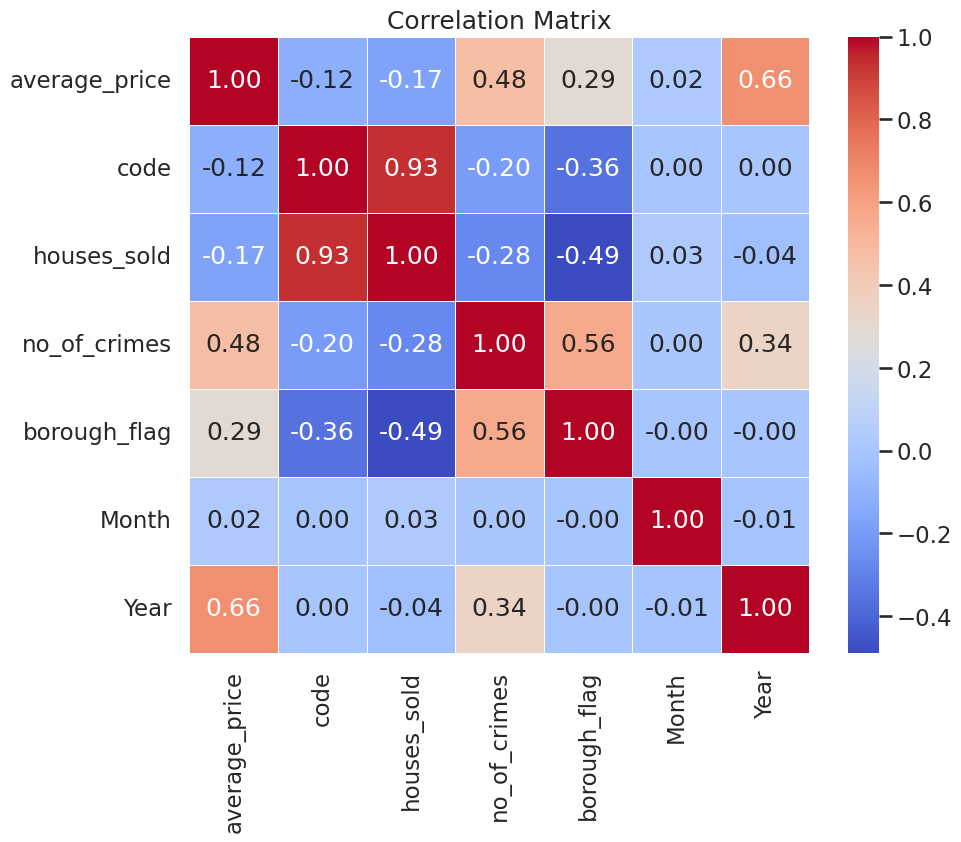

In [ ]:
correlation_matrix = df.corr()
# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Heatmap provides a visual summary of the relationships between different variables in the housing dataset.I have used correlation to check the other variables influencing on average_price. If correlation coefficient close to 1, it is positive linear relationship, as one variable increases, the other also increases proportionally.

average_price vs Year: 0.66 indicating a strong positive relationship.There is a tendency for average prices to increase as the years go by.

no_of_crimes vs. borough_flag:0.77, indicating a strong positive relationship.

average_price vs. houses_sold:-0.17, indicating a weak negative relationship.

average_price vs. no_of_crimes:0.25, indicating a weak positive relationship.

average_price vs. borough_flag:0.29, indicating a weak positive relationship.

houses_sold vs. no_of_crimes: -0.37, indicating a moderate negative relationship.

houses_sold vs. borough_flag: -0.49, indicating a moderate negative relationship.









Temporal Trends: The analysis explores temporal trends by examining the relationship between average property prices and the variable 'Year.' The identified positive correlation (R-squared of 0.66) indicates a consistent increase in average prices over the years, reflecting the dynamic nature of the real estate market.

Crime Rates and Housing: The correlation analysis reveals interesting relationships between average property prices and other variables. For instance, the positive correlation (0.25) between average prices and the number of crimes suggests a nuanced interaction between housing dynamics and the safety perception of an area.

# **Exploratory data analysis**

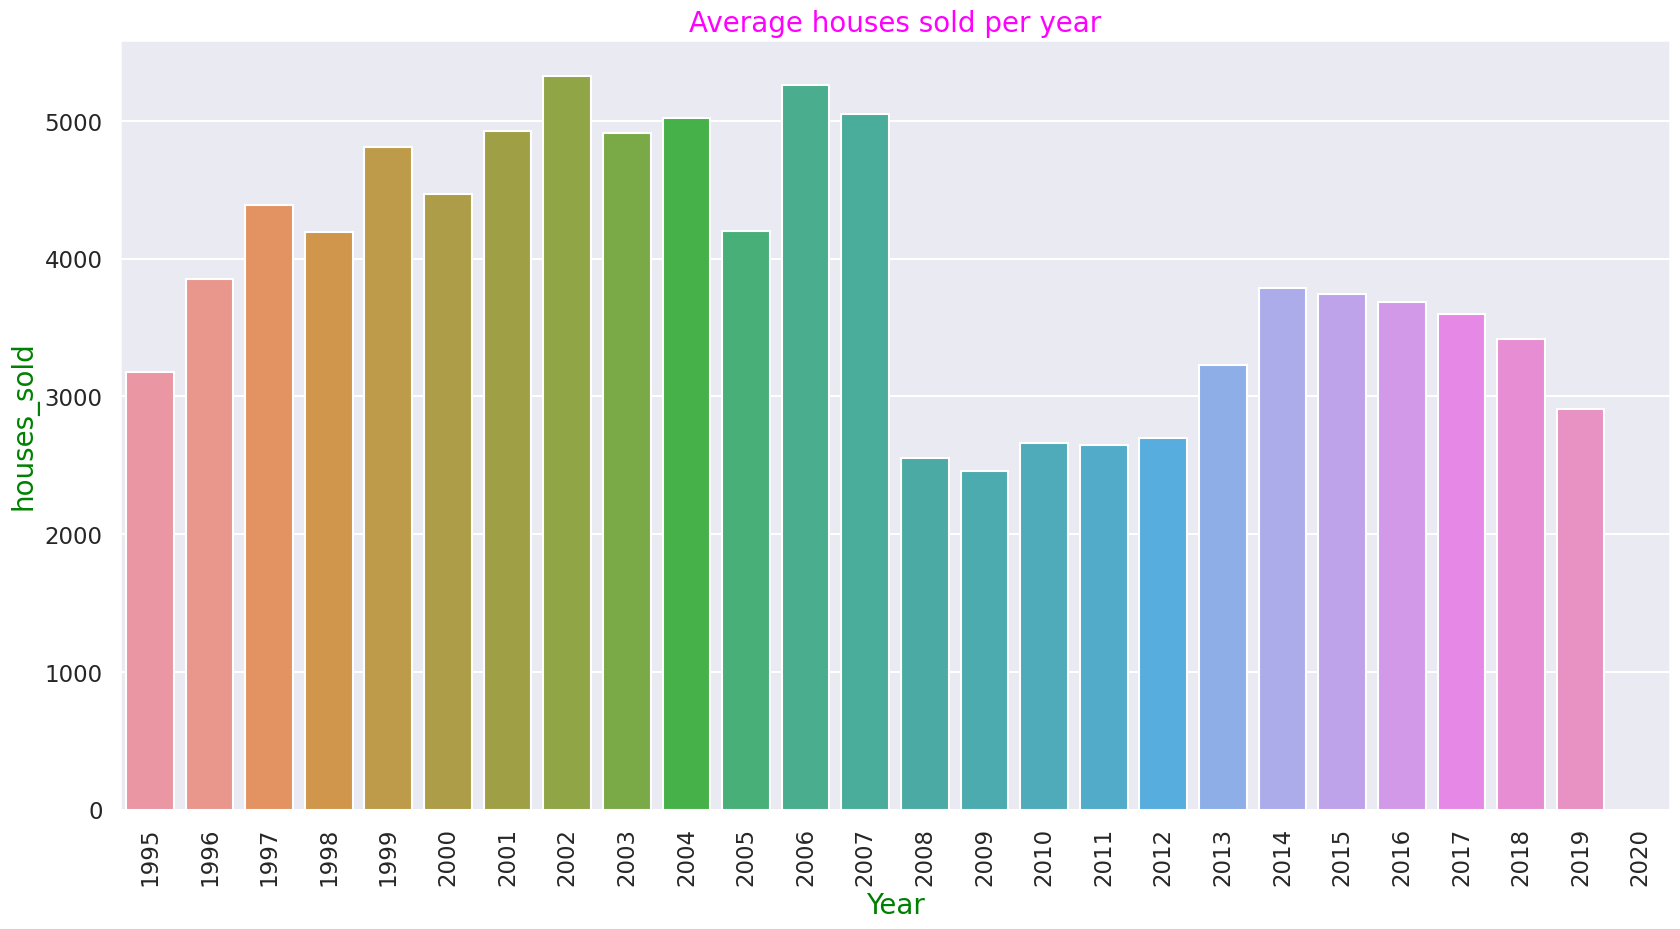

In [ ]:
# Grouping by Year and calculating the mean of average_price
no_house_sold = df.groupby("Year")["houses_sold"].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=[20,10])
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Year", fontsize=20, color="g")
plt.ylabel("houses_sold", fontsize=20, color="g")
plt.title("Average houses sold per year", color="magenta", fontsize=20)

# Using Seaborn to create a bar plot
sns.barplot(x="Year", y="houses_sold", data=no_house_sold)  # Specify x and y explicitly

# Setting the context and style for Seaborn
sns.set_context("talk")
sns.set_style("dark")

# Display the plot
plt.show()

The Bar graph shows the average houses sold per year. It reveals in decreasing trend in houses sold after the year 2007.

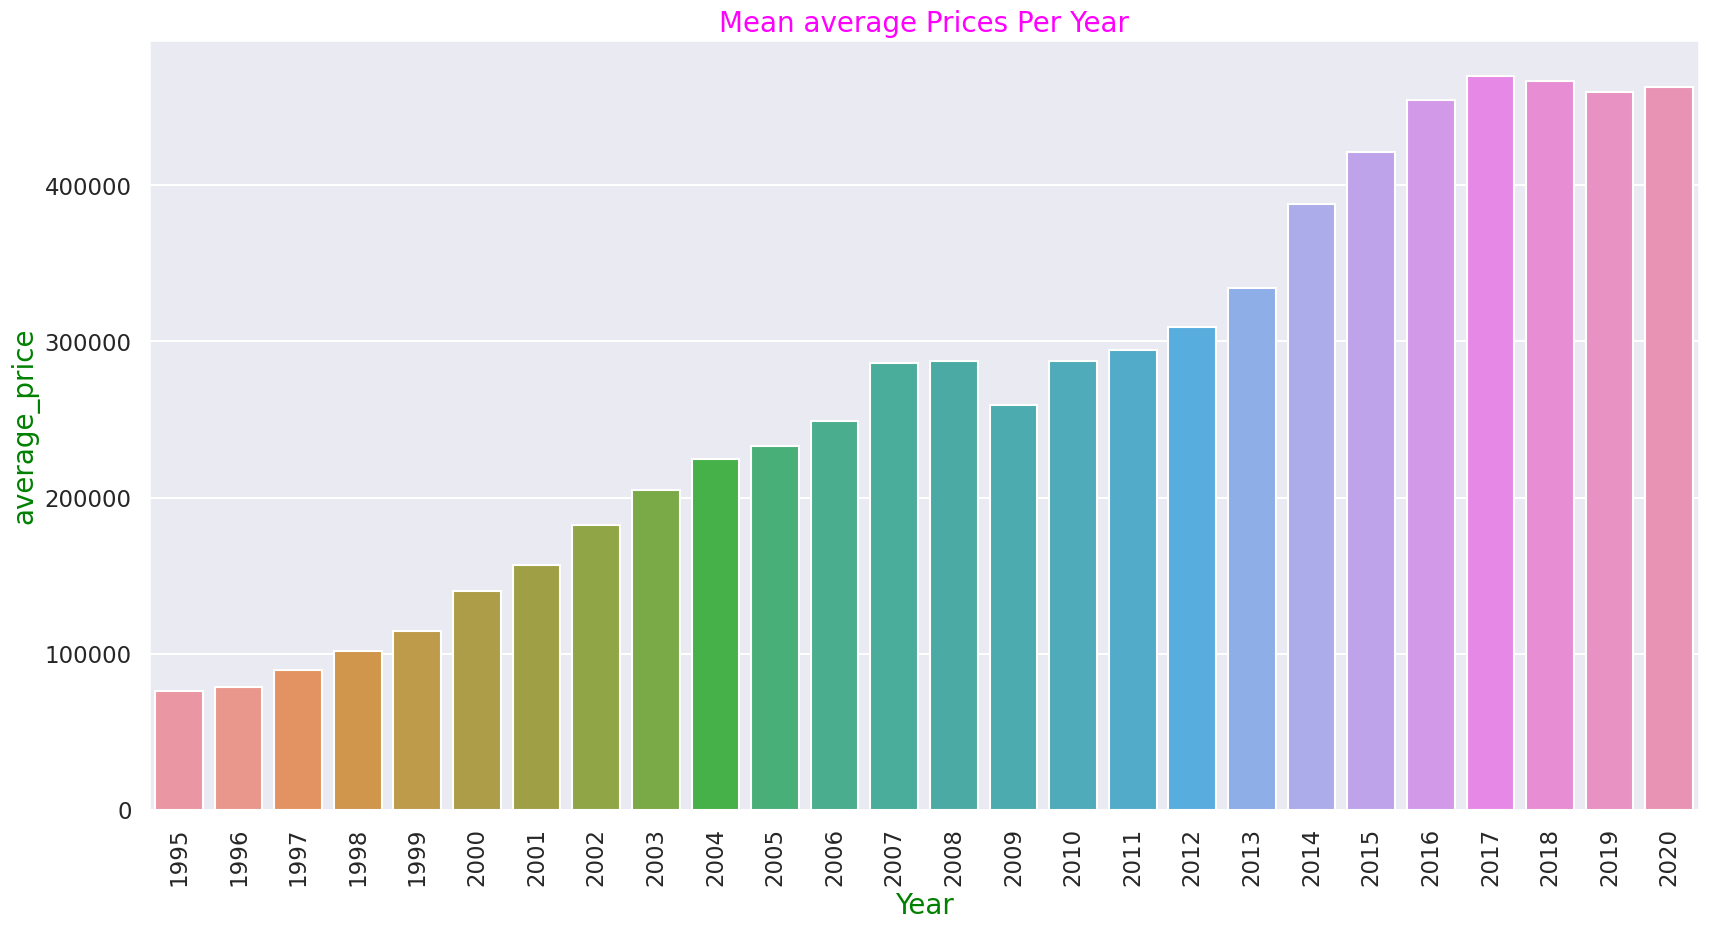

In [ ]:
# Grouping by Year and calculating the mean of average_price
no_house_sold = df.groupby("Year")["average_price"].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=[20,10])
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Year", fontsize=20, color="g")
plt.ylabel("average_price", fontsize=20, color="g")
plt.title("Mean average Prices Per Year", color="magenta", fontsize=20)

# Using Seaborn to create a bar plot
sns.barplot(x="Year", y="average_price", data=no_house_sold)  # Specify x and y explicitly

# Setting the context and style for Seaborn
sns.set_context("talk")
sns.set_style("dark")

# Display the Bar plot
plt.show()

First Dataframe is created for each unique year by Mean value of the average price.Then Bar graph depicts the mean average price increases by year.Positive trend of increasing mean average prices over the years.

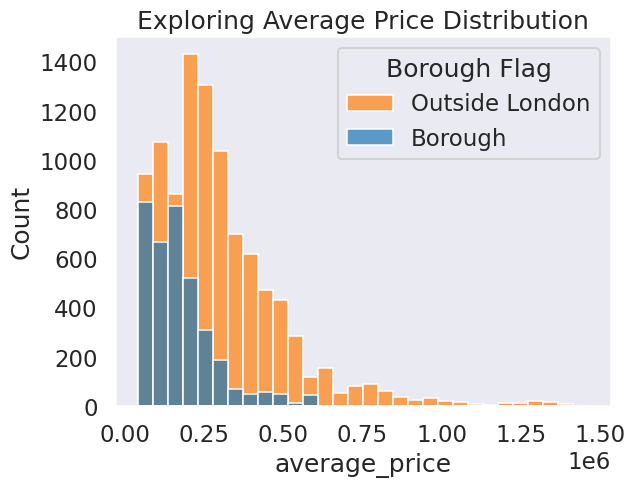

In [ ]:
# Plot the histogram with color based on 'borough_flag'
sns.histplot(data=df, x='average_price', kde=False, hue='borough_flag', bins=30, alpha=0.7)

# Add a legend
plt.legend(title='Borough Flag', labels=['Outside London', 'Borough'])

# Add a title
plt.title('Exploring Average Price Distribution')

# Show the plot
plt.show()

Price Histogram shows the distribution Double-Peaked or Bimodal with Right-skewed to the area of borough flag 1 & 0.

Total count for London boroughs (borough_flag = 1): 9936
Total count for areas outside London (borough_flag = 0): 3613


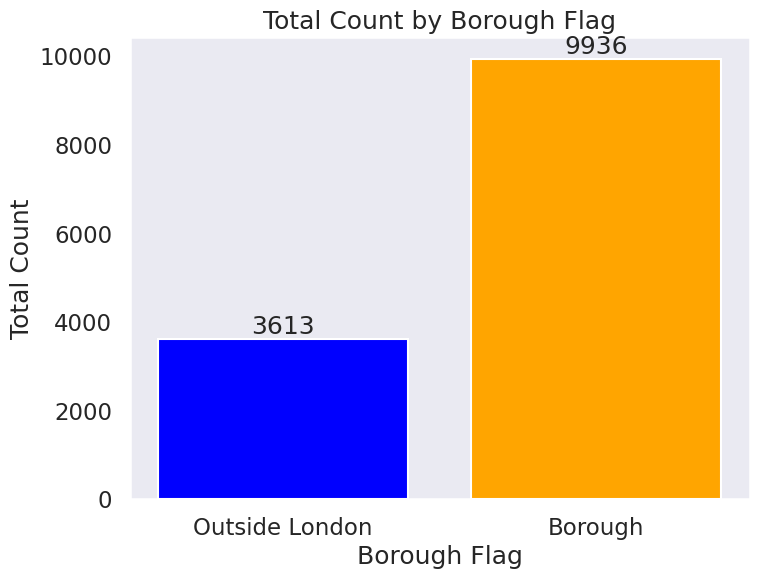

In [ ]:

# borough_flag has 1 and 0 value, total count of rows for each unique 'borough_flag' value
total_count_by_flag = df.groupby('borough_flag').size().reset_index(name='total_count')

# Separate counts for London and Outside London
count_london = total_count_by_flag.loc[total_count_by_flag['borough_flag'] == 1, 'total_count'].values[0]
count_outside_london = total_count_by_flag.loc[total_count_by_flag['borough_flag'] == 0, 'total_count'].values[0]

# Display the counts
print(f"Total count for London boroughs (borough_flag = 1): {count_london}")
print(f"Total count for areas outside London (borough_flag = 0): {count_outside_london}")

# Create a neat bar plot for total counts by Borough Flag
plt.figure(figsize=(8, 6))

# Bar plot
plt.bar(['Outside London', 'Borough'], [count_outside_london, count_london], color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Borough Flag')
plt.ylabel('Total Count')
plt.title('Total Count by Borough Flag')

# Display counts on top of each bar
for i, count in enumerate([count_outside_london, count_london]):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Show the bar plot
plt.show()

Borough_flag has 1 and 0 value,Creating new dataframe that has total count of rows for each unique 'borough_flag' value.
1.Total count for London boroughs (borough_flag = 1): 9936
2.Total count for areas outside London (borough_flag = 0): 3613

## **London boroughs vs Outside London** (Project is focused on London boroughs)

London boroughs are the 32 local authority districts that together with the City of London (Total 33).
Outside London there are 12 areas.

In [ ]:
# check number of boroughs (unique values from the 'area' column)
boroughs = df[df['borough_flag'] == 1]['area'].unique()
print('Number of boroughs in dataset : %d' %(len(boroughs)))

Number of boroughs in dataset : 33


In [ ]:
# Prints 33 boroughs names
for i, name in enumerate(boroughs):
  print(i+1,':', name)


1 : city of london
2 : barking and dagenham
3 : barnet
4 : bexley
5 : brent
6 : bromley
7 : camden
8 : croydon
9 : ealing
10 : enfield
11 : tower hamlets
12 : greenwich
13 : hackney
14 : hammersmith and fulham
15 : haringey
16 : harrow
17 : havering
18 : hillingdon
19 : hounslow
20 : islington
21 : kensington and chelsea
22 : kingston upon thames
23 : lambeth
24 : lewisham
25 : merton
26 : newham
27 : redbridge
28 : richmond upon thames
29 : southwark
30 : sutton
31 : waltham forest
32 : wandsworth
33 : westminster


Loop prints the index (incremented by 1 to start from 1) and the name of each borough. During each iteration, enumerate function to gets both the index (i) and the borough name (name) .

In [ ]:
# Create a new column 'borough_type' based on 'borough_flag'
df['borough_Flag'] = df['borough_flag'].apply(lambda x: '1' if x == 1 else '0')

# Boxplot
fig = px.box(df, x="average_price", template='simple_white', title='Average house price (1995 - 2020)',
             width=700, height=500, color='borough_Flag')

fig.show()

 Boxplot shows the distribution of average house prices by 'borough_flag'.It shows more dispersed distribution of house prices. Points beyond the whiskers are considered as outliers. Some areas in boroughs area have very high prices.  

In [ ]:
# Histogram
fig = px.histogram(df, x="average_price", y="houses_sold", template='simple_white',
                   title='Total houses sold (1995 - 2020)',
                   width=700, height=500, color='borough_flag', nbins=20)
fig.update_traces(opacity=0.75)
fig.show()

# Total houses sold in millions
total_houses_sold = round(df.groupby('borough_flag')['houses_sold'].sum() / 1000000, 1)
total_houses_sold_df = total_houses_sold.to_frame(name='Total houses sold (Million)')

# Add a new column for borough type
total_houses_sold_df['Borough Type'] = total_houses_sold_df.index.map({1: 'London borough', 0: 'Outside London'})

print(total_houses_sold_df)

              Total houses sold (Million)    Borough Type
borough_flag                                             
0                                    49.6  Outside London
1                                     3.2  London borough


Histogram shows distribution of houses sold in  average price by each category of borough_flag.
Table provide information about the total houses sold in millions for each 'borough_flag' category. In Outside London, the total house sold is 49.6 million, and London borough ('borough_flag' 1), the total house sold is 3.2 million.The houses sold of outside London are outnumbered London boroughs.







**The change of house prices over 25 years**

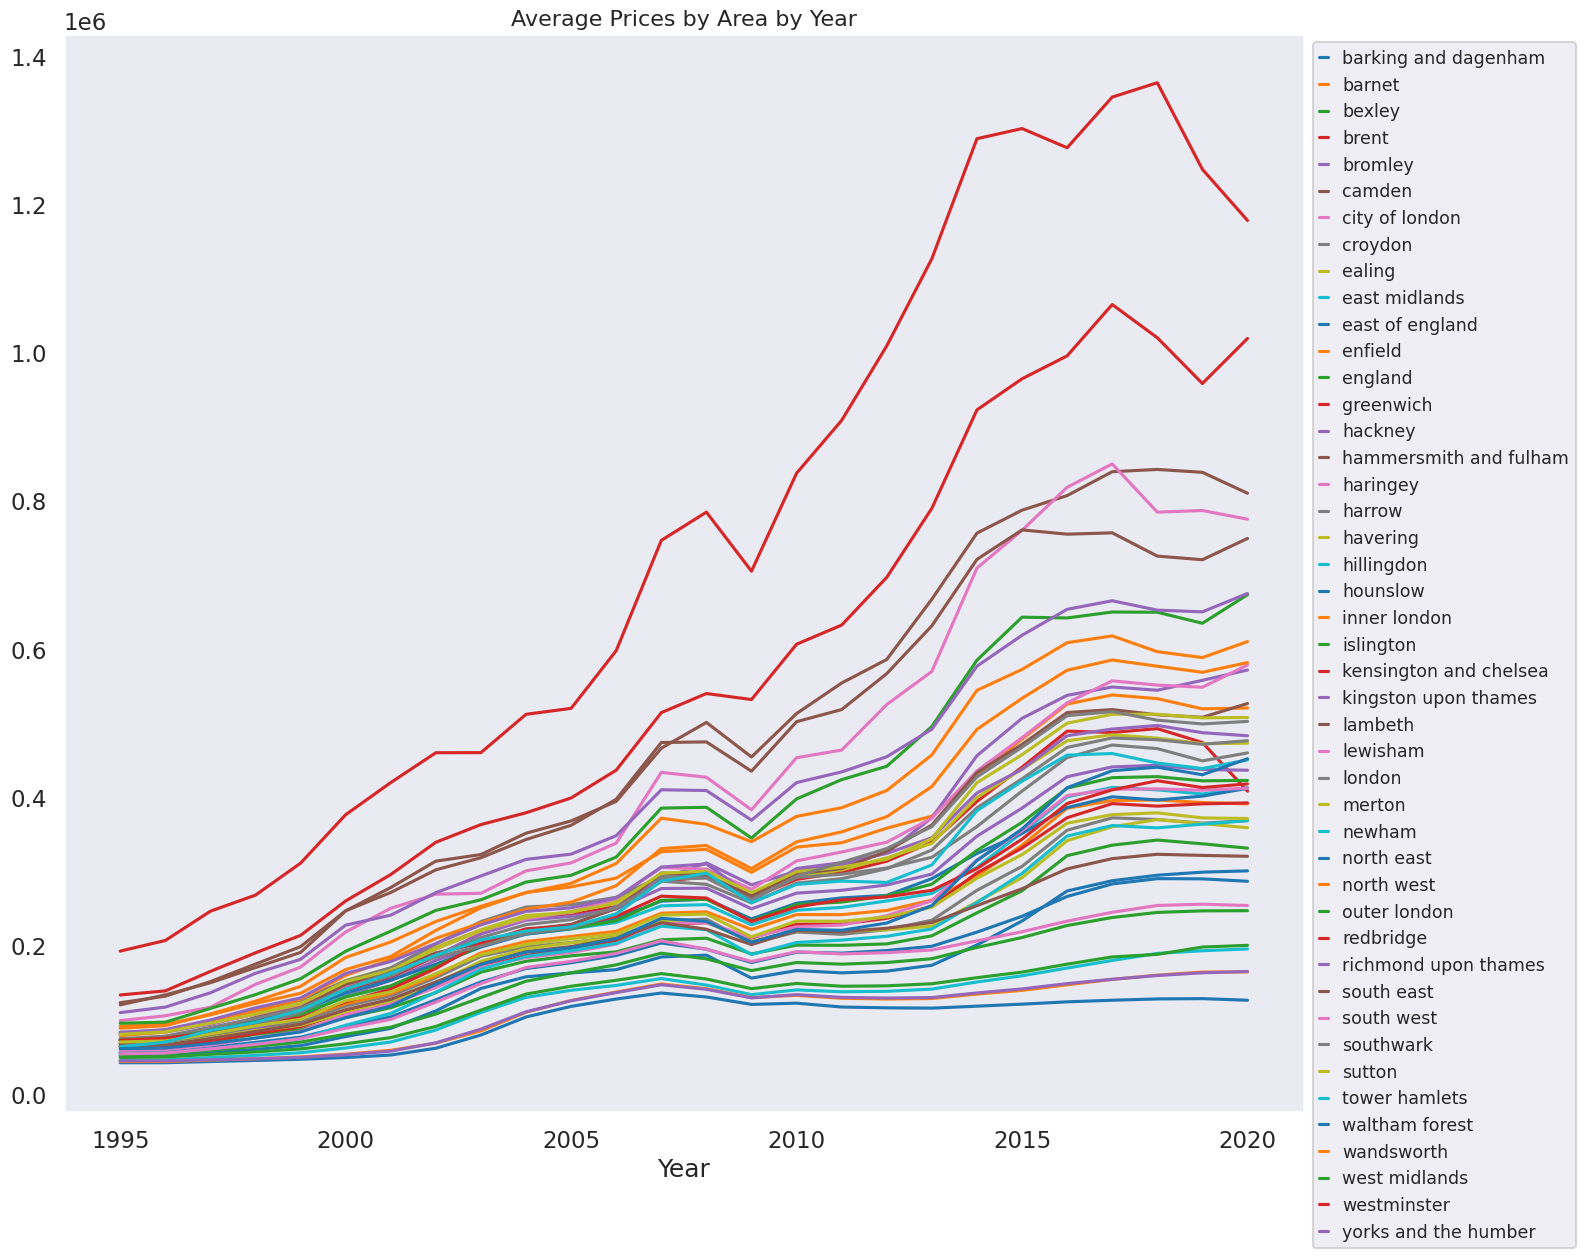

In [ ]:
# Step 1: Group by 'Year' and 'area', calculate the mean
df2 = df.groupby(['Year', 'area']).mean()

# Step 2: Unstack the DataFrame to make 'area' columns
df3 = df2.unstack()['average_price']

# Step 3: Plot the DataFrame
ax = df3.plot(figsize=(16, 14))

# Step 4: Adjust legend size, position, and length
ax.legend(fontsize='x-small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1, handlelength=0.50)

# Step 5: Add title
ax.set_title('Average Prices by Area by Year', fontsize=16)

# Display the plot
plt.show()


Line graph shows us the remarkable increase in average house prices as year goes on by area.Kensington and chelsea, westminter and camden area are expensive to buy houses.

In [ ]:
#Price changes over 25 years
df_date_price = df.groupby(['date','borough_flag'])['average_price'].mean().to_frame().reset_index()
fig = px.line(df_date_price, x='date', y= 'average_price' , template = 'simple_white', title ='The change of house prices over 25 years',
              width=800, height=400 , color = 'borough_flag',color_discrete_sequence=["orange", "steelblue"],
              category_orders={"borough_flag": ["0", "1"]}  )
fig.show()

Line graph shows us the remarkable increase in average house prices as year goes on . From 1995 to 2020, house prices in London boroughs went up a lot, from about £82,000 to around £528,000 in 25 years. Prices vary a lot among boroughs, starting at £50,000 and going up to about £1.5 million!

Outside of London, house prices went up more slowly, from £57,000 to about £290,000, which is almost 1.8 times less than in London boroughs.

In 2008-2009, there was a big drop in house prices for both London boroughs and outside London. This happened because of the financial crash in 2007-2009, which was a tough time for the economy.


# **London Borough area Analysis (Project is based on Borough area)**

In [ ]:
#title Most expensive area in Boroughs
# Look into mean average price houses in each area of borough
df_boroughs = df[df['borough_flag'] == 1]
df_boroughs_mean = round(df_boroughs.groupby('area')['average_price'].mean(),2).sort_values().to_frame().reset_index()

# Convert 'average_price' to integer
df_boroughs_mean['average_price'] = df_boroughs_mean['average_price'].astype(int)

# plotting the bar chart
fig = px.bar(df_boroughs_mean, x="average_price", y="area",text="average_price", template = 'simple_white', title ='Which borough area is the most expensive ?',
              width=800, height=1000 , orientation = 'h' )
fig.update_traces(opacity=0.75)
fig.show()

Horizontal Bar Graph shows expensive area in London Borough. The bar graph visualizes the mean average prices of houses by 33 areas in London Boroughs.Kensington and chelsea, westminter and camden are expensive areas. Houses are sold in very high prices. The mean average price for houses in the Kensington area is £742,060. However, if I were to consider purchasing a house in Kensington, I would be looking at a price range around £700,000.

In [ ]:
#title Most Houses sold in boroughs
df_boroughs_sold_sum = df_boroughs.groupby('area')['houses_sold'].sum().sort_values().to_frame().reset_index()

fig = px.bar(df_boroughs_sold_sum, x="houses_sold", y="area",text="houses_sold", template = 'simple_white', title ='How many houses sold in London boroughs?',
              width=800, height=1000 , orientation = 'h' )
fig.update_traces(opacity=0.75)
fig.show()

A horizontal bar graph depicts the total number of houses sold across 33 areas in London Boroughs.

Notably, Wandsworth, Bromley, and Croydon are standout areas with particularly high numbers of houses sold.
In the case of Wandsworth, a substantial 164,967 houses were sold from 1995 to 2020, showcasing a noteworthy level of real estate activity in that area.

It's interesting to observe that the City of London has a comparatively lower total of 7,636 houses sold from 1995 to 2020.

# Top 10 Crime Areas(1995-2020)

In [ ]:
top_10_crimes = df.groupby('area')['no_of_crimes'].sum().nlargest(10).reset_index()

# Reverse the order of the dataframe
top_10_crimes = top_10_crimes[::-1]

# Create a horizontal bar chart using plotly
fig = px.bar(top_10_crimes, x='no_of_crimes', y='area', text='no_of_crimes',
             orientation='h', template='simple_white',
             title='Top 10 Crime Areas (1995-2020)',
             labels={'no_of_crimes': 'Number of Crimes', 'area': 'Area'},
             color='no_of_crimes',  # Use 'no_of_crimes' for color scaling
             color_continuous_scale='Reds',  # Use the Reds color scale
             )

# Adjust layout for better appearance
fig.update_layout(width=900, height=600)
fig.update_traces(opacity=0.90)

# Show the plot
fig.show()


Horizontal Bar graph shows top 10 areas with the highest number of crimes from 1995 to 2020.Graph is generated using Plotly Express.

The df.groupby('area')['no_of_crimes'].sum().nlargest(10).reset_index() part of the code groups the data by area, sums up the number of crimes for each area, selects the top 10 areas with the largest sum, and then resets the index for better plotting.


Analysis of crime data spanning from 1995 to 2020 reveals that Westminster, Lambeth, and Camden are among the top areas in London with the highest incidences of reported crimes. Westminster, in particular, stands out with a staggering total of 1,592,695 crimes over this period. This data raises concerns about the safety and security of these areas, with Westminster being notably identified as a location with a substantial number of reported crimes, suggesting potential challenges related to public safety

# **Model Implementation**

In [ ]:
df_boroughs = df[df['borough_flag'] == 1]

def preprocessing_data(df=df_boroughs, training_size=0.8):

    # Drop unnecessary features
    df_predict = df.drop(columns =['code','borough_flag','date'])

    # one hot encoding
    ohe = pd.get_dummies(df_predict['area'], drop_first=True)
    df_predict = pd.concat([df_predict, ohe], axis=1)
    df_predict = df_predict.drop(columns=['area'], axis=1)

    # Given x, y
    x = df_predict.drop(columns=['average_price'])
    y = df_predict['average_price']

    # Train-test split (train data 80%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=training_size, shuffle=True, random_state=42)

    # Standard scaling x
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocessing_data()


The initial step involves filtering the dataset to focus specifically on borough-related information. Subsequently, irrelevant features such as 'code,' 'borough_flag,' and 'date' are excluded, streamlining the dataset for analysis. Month and Year is extracted from date column,so we are excluding date feature.
 The categorical variable 'area' is then subjected to one-hot encoding to facilitate machine learning algorithms' , to avoid multicollinearity. Following this, the dataset is divided into training and testing sets, constituting 80% and 20% of the data, respectively, to evaluate model performance effectively. The features undergo standard scaling, a critical step in ensuring that numerical variables are on a comparable scale, preventing any particular feature from dominating the model training process.


In [ ]:
# Check x_train
x_train.sample(5)

,houses_sold,no_of_crimes,Month,Year,barnet,bexley,brent,bromley,camden,city of london,...,merton,newham,redbridge,richmond upon thames,southwark,sutton,tower hamlets,waltham forest,wandsworth,westminster
1457,-0.720055,0.427710,-1.290912,1.242192,-0.176076,-0.175696,5.655020,-0.172241,-0.183899,-0.175696,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
8770,-0.147288,-1.331327,-1.579964,-1.250590,-0.176076,-0.175696,-0.176834,-0.172241,-0.183899,-0.175696,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,5.667157,-0.177966,-0.177966,-0.172628
7131,-0.638231,-0.318022,1.310551,0.549752,-0.176076,-0.175696,-0.176834,-0.172241,-0.183899,-0.175696,...,5.437760,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
2925,-0.774604,0.375682,1.021499,0.688240,-0.176076,-0.175696,-0.176834,-0.172241,-0.183899,-0.175696,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
541,-0.754148,-0.251129,-1.579964,1.103704,-0.176076,-0.175696,-0.176834,-0.172241,-0.183899,-0.175696,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628


In [ ]:
# check y_train
y_train.sample(5)

2276    204911
7113    301425
9455    271443
8270    241407
8253    219026
Name: average_price, dtype: int64

+-----------------------+--------------------+-------------------+--------------------+
|        Models         |     R-squared      |        MSE        |        RMSE        |
+-----------------------+--------------------+-------------------+--------------------+
| DecisionTreeRegressor | 0.9912204994365463 | 339064679.168008  | 18413.709000850646 |
|  KNeighborsRegressor  | 0.9797950731543452 | 780315120.3216096 | 27934.121076590356 |
|         Lasso         | 0.8636355412546941 | 5266401103.368409 | 72569.97384158554  |
|   LinearRegression    | 0.8636340122989287 | 5266460151.704052 | 72570.38067768456  |
+-----------------------+--------------------+-------------------+--------------------+


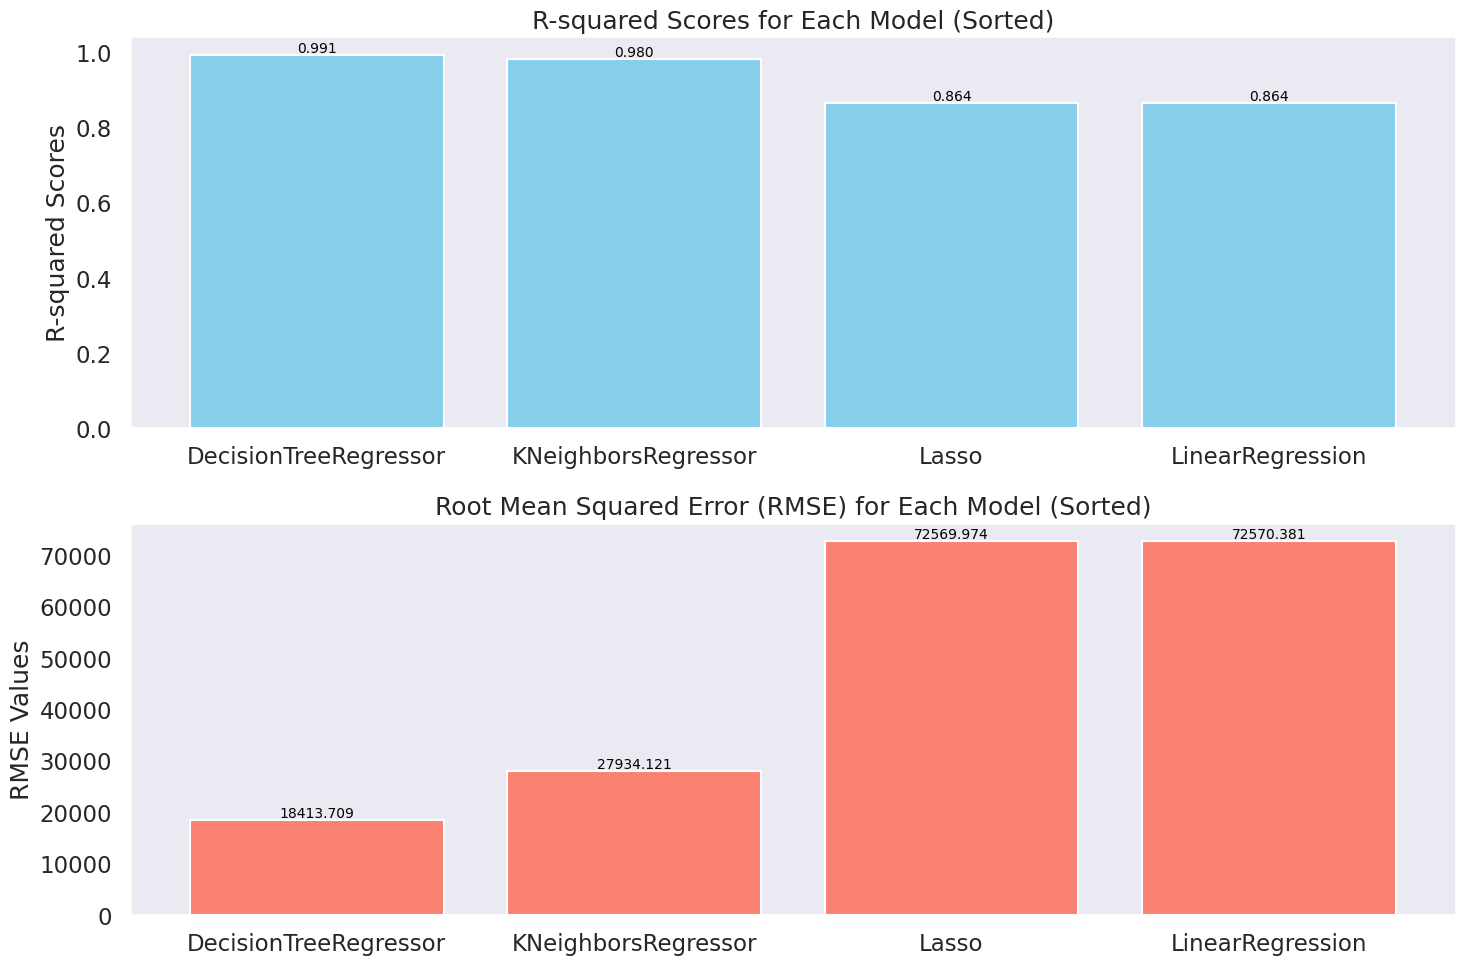

In [ ]:
# Initialize models
tree = DecisionTreeRegressor()
la = Lasso()
reg = LinearRegression()
knn = KNeighborsRegressor()

# Fit models
reg.fit(x_train, y_train)
tree.fit(x_train, y_train)
la.fit(x_train, y_train)
knn.fit(x_train, y_train)

# Make predictions
pd1 = reg.predict(x_test)
pd3 = tree.predict(x_test)
pd4 = la.predict(x_test)
pd5 = knn.predict(x_test)

# Calculate R-squared scores
s1 = r2_score(y_test, pd1)
s3 = r2_score(y_test, pd3)
s4 = r2_score(y_test, pd4)
s5 = r2_score(y_test, pd5)

# Create a DataFrame for visualization
Models = ["LinearRegression", "DecisionTreeRegressor", "Lasso", "KNeighborsRegressor"]
Scores = [s1, s3, s4, s5]

df = pd.DataFrame({"Models": Models, "Scores": Scores})

# Calculate MSE for each model
mse1 = mean_squared_error(y_test, pd1)
mse3 = mean_squared_error(y_test, pd3)
mse4 = mean_squared_error(y_test, pd4)
mse5 = mean_squared_error(y_test, pd5)

# Calculate RMSE for each model
rmse1 = np.sqrt(mse1)
rmse3 = np.sqrt(mse3)
rmse4 = np.sqrt(mse4)
rmse5 = np.sqrt(mse5)

# Create a DataFrame for the table
data = {
    "Models": Models,
    "R-squared": Scores,
    "MSE": [mse1, mse3, mse4, mse5],
    "RMSE": [rmse1, rmse3, rmse4, rmse5]
}

table_df = pd.DataFrame(data)

# Sort the DataFrame by R-squared in descending order
table_df = table_df.sort_values(by="R-squared", ascending=False)

# Format the table using tabulate
table_str = tabulate(table_df, headers='keys', tablefmt='pretty', showindex=False)

# Display the formatted table
print(table_str)

# Plot R-squared and RMSE
plt.figure(figsize=[15, 10])

# Plot R-squared (sorted by R-squared)
plt.subplot(2, 1, 1)
bars_r2 = plt.bar(table_df["Models"], table_df["R-squared"], color='skyblue')  # Use skyblue color
plt.ylabel("R-squared Scores")
plt.title("R-squared Scores for Each Model (Sorted)")

# Annotate R-squared values on top of each bar
for i, (bar, score) in enumerate(zip(bars_r2, table_df["R-squared"])):
    plt.text(i, bar.get_height(), f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=10)

# Plot RMSE (sorted by R-squared)
plt.subplot(2, 1, 2)
bars_rmse = plt.bar(table_df["Models"], table_df["RMSE"], color='salmon')  # Use salmon color
plt.ylabel("RMSE Values")
plt.title("Root Mean Squared Error (RMSE) for Each Model (Sorted)")

# Annotate RMSE values on top of each bar
for i, (bar, rmse_value) in enumerate(zip(bars_rmse, table_df["RMSE"])):
    plt.text(i, bar.get_height(), f'{rmse_value:.3f}', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()


The Decision Tree Regressor is the the top-performing model, achieving an exceptional R-squared score of 0.9915, demonstrating its capability to explain nearly 99.15% of the variance in average property prices in London boroughs.The Decision Tree Regressor's impressive performance is further underscored by a relatively low Mean Squared Error (MSE) of 328,344,984 and a corresponding Root Mean Squared Error (RMSE) of 18,120.29, indicating accurate predictions with minimal error.

# **Hyper parameter tuning**

In [ ]:
# hyperparameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search model
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Fit the model with the best parameters
best_model = DecisionTreeRegressor(**best_params)
best_model.fit(x_train, y_train)

# Make predictions
best_predictions = best_model.predict(x_test)

# Calculate R-squared for the tuned model
best_score = r2_score(y_test, best_predictions)

# Print the results
print(f"Best Parameters: {best_params}")
print(f"R-squared (Tuned DecisionTreeRegressor): {best_score}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
R-squared (Tuned DecisionTreeRegressor): 0.991679310903723


R-squared for DecisionTreeRegressor (Before Tuning): 0.99187
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}
R-squared for Tuned DecisionTreeRegressor: 0.9911

The decrease in R-squared might be due to various reasons:

Overfitting: The tuned model might have learned to fit the training data too closely, leading to a decrease in performance on the test data.

Noise in Data: The tuning might have exposed the model to noise in the data, affecting its generalization.

Complexity: Increasing the complexity of the model (e.g., increasing max_depth) could lead to overfitting.

# **Which is the Best Model?**

Decision Tree Regressor is the best model to predict average house price in London Borough. Decision Tree Regressor and K-Nearest Neighbors Regressor outperform Lasso and Linear Regression models. Decision Tree Regressor identified as the model of choice for its superior performance.

MSE for LinearRegression: 5266460151.704052
RMSE for LinearRegression: 72570.38067768456
R2 for LinearRegression: 0.8636340122989287


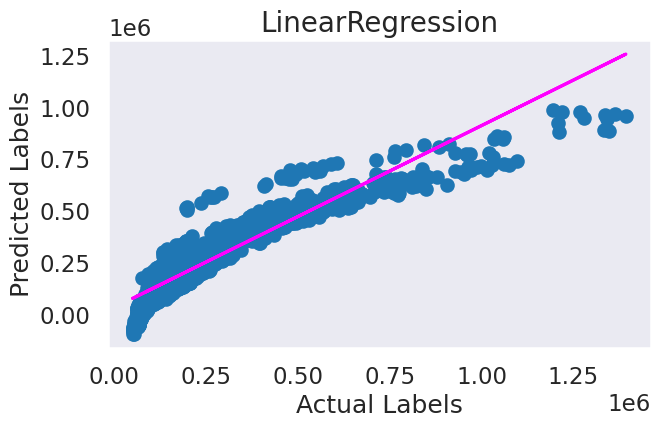

MSE for DecisionTreeRegressor: 339064679.168008
RMSE for DecisionTreeRegressor: 18413.709000850646
R2 for DecisionTreeRegressor: 0.9912204994365463


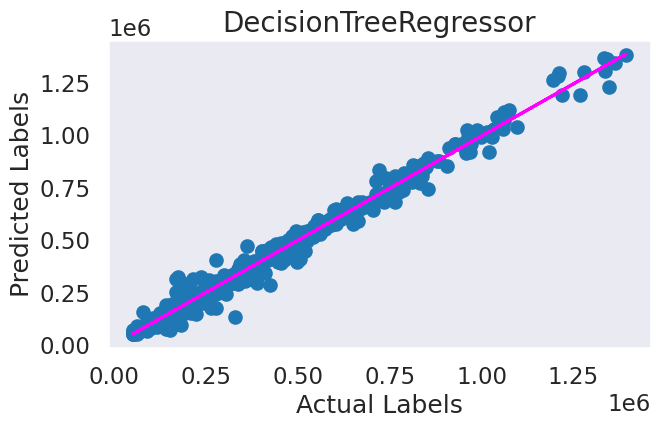

MSE for Lasso: 5266401103.368409
RMSE for Lasso: 72569.97384158554
R2 for Lasso: 0.8636355412546941


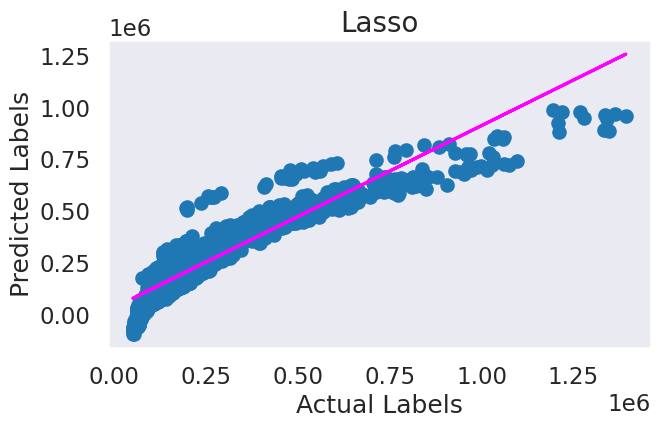

MSE for KNeighborsRegressor: 780315120.3216096
RMSE for KNeighborsRegressor: 27934.121076590356
R2 for KNeighborsRegressor: 0.9797950731543452


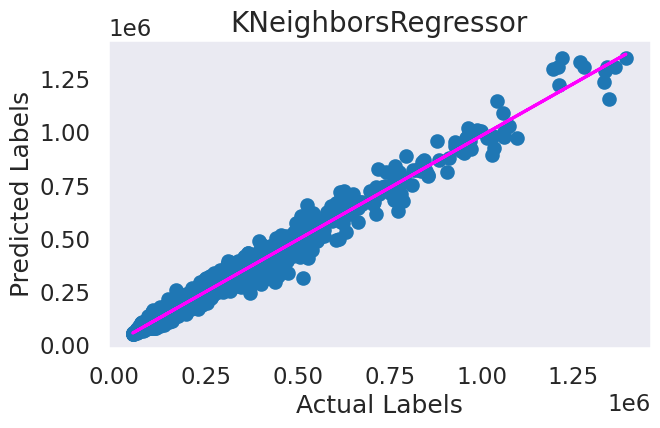

In [ ]:

# Loop through each model
for model, predictions in zip(Models, [pd1, pd3, pd4, pd5]):
    # Calculate MSE
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE for {model}:", mse)

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE for {model}:", rmse)

    # Calculate R2
    r2 = r2_score(y_test, predictions)
    print(f"R2 for {model}:", r2)

    # Plot predicted vs actual
    plt.figure(figsize=(7, 4))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title(model, fontsize=20)

    # Overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color='magenta')

    plt.show()


# **Result**

In [ ]:
# Convert predictions to whole numbers
pd3 = pd3.astype(int)
pd5 = pd5.astype(int)

# Calculate differences for DecisionTreeRegressor
diff_decision_tree = y_test - pd3

# Calculate differences for KNeighborsRegressor
diff_k_neighbors = y_test - pd5

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted(DecisionTree)': pd3,
    'Difference(DecisionTree)': diff_decision_tree,
    'Predicted (KNN) £': pd5,
    'Difference (KNN) £': diff_k_neighbors
})

# results in a formatted table
table_str = tabulate(results_df.head(10), headers='keys', tablefmt='pretty', showindex=False)
print(table_str)


+--------+-------------------------+--------------------------+-------------------+--------------------+
| Actual | Predicted(DecisionTree) | Difference(DecisionTree) | Predicted (KNN) £ | Difference (KNN) £ |
+--------+-------------------------+--------------------------+-------------------+--------------------+
| 85518  |          80580          |           4938           |       82796       |        2722        |
| 190487 |         190394          |            93            |      186198       |        4289        |
| 188125 |         182876          |           5249           |      204667       |       -16542       |
| 71789  |          69124          |           2665           |       72349       |        -560        |
| 773678 |         740943          |          32735           |      715737       |       57941        |
| 137783 |         138797          |          -1014           |      105426       |       32357        |
| 282097 |         279643          |           2454    

In [ ]:
# Convert predictions to whole numbers
pd3 = pd3.astype(int)

# Calculate differences for DecisionTreeRegressor
diff_decision_tree = y_test - pd3

# Create a DataFrame for the results (DecisionTreeRegressor only)
results_decision_tree_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted(DecisionTree)': pd3,
    'Difference £ (DecisionTree)': diff_decision_tree
})

# Display the results in a formatted table
table_str_decision_tree = tabulate(results_decision_tree_df.head(10), headers='keys', tablefmt='pretty', showindex=False)
print(table_str_decision_tree)


+--------+-------------------------+-----------------------------+
| Actual | Predicted(DecisionTree) | Difference £ (DecisionTree) |
+--------+-------------------------+-----------------------------+
| 85518  |          71982          |            13536            |
| 190487 |         190394          |             93              |
| 188125 |         182876          |            5249             |
| 71789  |          69124          |            2665             |
| 773678 |         746424          |            27254            |
| 137783 |         138797          |            -1014            |
| 282097 |         279643          |            2454             |
| 324159 |         294225          |            29934            |
| 50849  |          51514          |            -665             |
| 197653 |         190368          |            7285             |
+--------+-------------------------+-----------------------------+


Quick assessment of the predictive accuracy and understanding of the disparities between predicted prices and actual property prices in the London Borough dataset.
Table represents the Actual house price in first column, model predicted values in 2nd column. The "Difference £ (DecisionTree)" column represents the disparity between actual and predicted prices for the DecisionTreeRegressor.


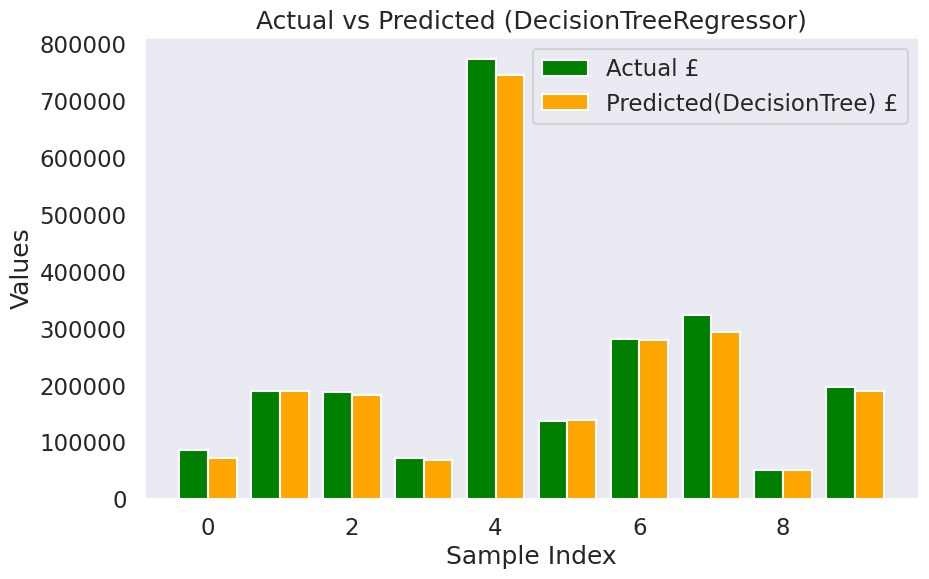

In [ ]:

# Select the first 10 rows for plotting
plot_data = results_df.head(10)

# Set up positions for bars
bar_width = 0.4
index = np.arange(len(plot_data))

# Plot Actual and Predicted values for DecisionTreeRegressor
plt.figure(figsize=(10, 6))
plt.bar(index - bar_width/2, plot_data['Actual'], width=bar_width, label='Actual £', color='green')
plt.bar(index + bar_width/2, plot_data['Predicted(DecisionTree)'], width=bar_width, label='Predicted(DecisionTree) £', color='orange')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted (DecisionTreeRegressor)')
plt.legend()
plt.show()

Bar plot visually compares the actual and predicted values for the DecisionTreeRegressor for the first 10 samples in your dataset. The green bars represent the actual values, and the orange bars represent the predicted values. Predicted values aligns with the actual values for each sample.

**End of Analysis , Thank you for your time ☘**





Name: Kavyashree

emailaddress:kavy012@gmail.com